In [91]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A. Set file path to parent directory

In [92]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "src"))
import os 
os.chdir("../")

In [93]:
Path().resolve()

PosixPath('/')

# 1. Import data from ILO

## 1.A Import

In [94]:
import pandas as pd
from src.data.download_oecd_ilo import get_industry_employment_data

df_ilo = get_industry_employment_data(start_year=2000, end_year=2023, output_filename="ilo_data_raw.csv")
df_ilo.head(2)

Fetching ILO data from: https://rplumber.ilo.org/data/indicator/?id=EMP_TEMP_ECO_OCU_NB_A&timefrom=2000&timeto=2023&classif1=ECO_SECTOR_IND&classif2=OCU_SKILL_TOTAL&format=.csv
Saving the dataset to: ilo_data_raw.csv


,ref_area,source,indicator,classif1,classif2,time,obs_value,obs_status,note_classif,note_indicator,note_source
0,ABW,AA:22,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2010,6.738,NaN,NaN,NaN,S3:20_T2:83
1,AFG,BA:15715,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2021,1463.372,NaN,NaN,NaN,R1:3513_S3:8


## 1.1 Inspect data

In [95]:
df_ilo.ref_area.unique()

array(['ABW', 'AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT',
       'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH',
       'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA',
       'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU',
       'DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FRA', 'FSM', 'GBR', 'GEO', 'GHA', 'GMB', 'GNB',
       'GRC', 'GRD', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JOR', 'JPN', 'KEN', 'KGZ', 'KHM', 'KIR', 'KOR', 'KOS', 'LAO',
       'LBN', 'LBR', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC',
       'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT',
       'MMR', 'MNE', 'MNG', 'MOZ', 'MSR', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA', 'NIC', 'NIU', 'NLD', 'NOR', 'NPL', 'NRU', 'OMN',
       'PAK', 'PAN',

## 1.2 Truncate data

In [96]:
df_ilo_extract = df_ilo.loc[df_ilo.ref_area.isin(["USA", "FRA"]), ["ref_area", "time", "obs_value"]]
df_ilo_extract.head(2)

,ref_area,time,obs_value
627,FRA,2023,5453.964
628,FRA,2022,5389.376


In [97]:
def_ilo_renamed = df_ilo_extract.rename({"ref_area": "country", "time": "year", "obs_value": "ILO"}, axis="columns")
df_ilo_clean = def_ilo_renamed.set_index(["country", "year"])
df_ilo_clean.head(2)

ILO
country year          
FRA     2023  5453.964
        2022  5389.376

# 2. Import data from OECD

In [98]:
from src.data.download_oecd_ilo import oecd_api_wrapper

In [99]:
# https://data-explorer.oecd.org/vis?fs[0]=T%2Co&pg=0&fc=Topic&bp=true&snb=68&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_ALFS%2540DF_SUMTAB&df[ag]=OECD.SDD.TPS&df[vs]=1.0&dq=........A&pd=%2C&to[TIME_PERIOD]=false&vw=ov
df_oecd = oecd_api_wrapper(
    agency_id="OECD.SDD.TPS",
    dataflow_id="DSD_ALFS%40DF_SUMTAB",
    dataflow_ver="1.0",
    dimensions=["all", "EMP", "PS", "all", "_T", "all", "all", "BTE", "A"],
    startPeriod=2000,
    endPeriod=2023,
    dimensionAtObservation="AllDimensions",
    format="csv",
    output_filename="oecd_data_raw.csv",
)
df_oecd.head(2)

Fetching OECD data from: https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_ALFS%40DF_SUMTAB,1.0/.EMP.PS.._T...BTE.A?startPeriod=2000&endPeriod=2023&dimensionAtObservation=AllDimensions&format=csv
Saving the dataset to: oecd_data_raw.csv


,You have exceeded the number of requests for data downloads or very large data ranges permitted in the OECD Data API. Please contact us through the OECD Data Explorer (https://data-explorer.oecd.org) feedback form (indicating your IP address) to request more details or exceptions.


## 2.1 Inspect data

In [100]:
df_oecd.REF_AREA.unique()

AttributeError: 'DataFrame' object has no attribute 'REF_AREA'

## 2.2 Filter data

In [ ]:
df_oecd_extract = df_oecd.loc[df_oecd.REF_AREA.isin(["USA", "FRA"]), ["REF_AREA", "TIME_PERIOD", "OBS_VALUE"]]
df_oecd_extract.head(2)

,REF_AREA,TIME_PERIOD,OBS_VALUE
64,FRA,2021,5252.70
65,FRA,2022,5373.95


In [ ]:
df_oecd_renamed = df_oecd_extract.rename({"REF_AREA": "country", "TIME_PERIOD": "year", "OBS_VALUE": "OECD"}, axis="columns")
df_oecd_clean = df_oecd_renamed.set_index(["country", "year"])
df_oecd_clean.head(2)

OECD
country year         
FRA     2021  5252.70
        2022  5373.95

# Merge data

In [ ]:
df_merge = pd.merge(
    df_ilo_clean,
    df_oecd_clean,
    right_index = True,
    left_index = True,
    how = 'inner'
)
df_merge.head(2)

ILO     OECD
country year                   
FRA     2023  5453.964  5453.95
        2022  5389.376  5373.95

In [ ]:
df_melt = pd.melt(df_merge.reset_index(), id_vars=["country", "year"], value_vars=["ILO", "OECD"], var_name="source", value_name="employment")
df_melt.head(2)

,country,year,source,employment
0,FRA,2023,ILO,5453.964
1,FRA,2022,ILO,5389.376


# Graph data

In [ ]:
####
# import matplotlib.pyplot as plt
# import seaborn as sns

# g = FacetGrid(1,2,sharey=False)
# g = sns.relplot(data=df_melt, x="year", y="employment", hue="source", col="country", kind="line", facet_kws={'sharey': False})
# g.set
#####

# CAN YOU PLEASE DESCRIBE THE COMTRAD DATA 

- Were you unable to download it from the comtrad API?
    - Please

In [ ]:
from src.data.download_comtrad import get_un_trade_data

In [ ]:
UN_API_KEY = "<YOUR_KEY>"

In [ ]:
df_un_trade = get_un_trade_data("3562ddaae00c4520afaa81f05bf0d83a")
df_un_trade.head(2)

/workspaces/graspp-25S-trade/src/data/download_comtrad.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(list_df)


,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,19880101,1988,52,1988,36,AUS,Australia,M,...,NaN,False,NaN,False,NaN,3.302574e+10,3.302574e+10,0,False,False
1,C,A,19880101,1988,52,1988,36,AUS,Australia,X,...,NaN,False,NaN,False,NaN,3.220539e+10,3.220539e+10,0,False,False


In [ ]:
df_trade_extract = df_un_trade[['reporterDesc', 'refYear', 'primaryValue', 'flowDesc']].dropna()
df_trade_rename = df_trade_extract.rename({"reporterDesc":'country', "refYear":'year', "primaryValue":'total trade value',"flowDesc":'import or export'}, axis=1)
df_trade_clean = df_trade_rename.pivot(index=['country', 'year'], columns="import or export", values="total trade value")

df_trade_clean.info()
df_trade_clean.head(2)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5198 entries, ('Afghanistan', np.int64(2008)) to ('Zimbabwe', np.int64(2024))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Export  5143 non-null   float64
 1   Import  5164 non-null   float64
dtypes: float64(2)
memory usage: 107.6+ KB


import or export       Export        Import
country     year                           
Afghanistan 2008  540065594.0  3.019860e+09
            2009  403441006.0  3.336435e+09

In [ ]:
df_melt = df_melt.set_index(['country', 'year'])

In [ ]:
df_merge = pd.merge(
    df_trade_clean,
    df_ilo_clean,
    right_index = True,
    left_index = True,
    how = 'inner'
)
df_merge.tail(2)

Export        Import        ILO
country year                                       
USA     2022  2.062090e+12  3.372902e+12  30513.430
        2023  2.018543e+12  3.168471e+12  31137.472

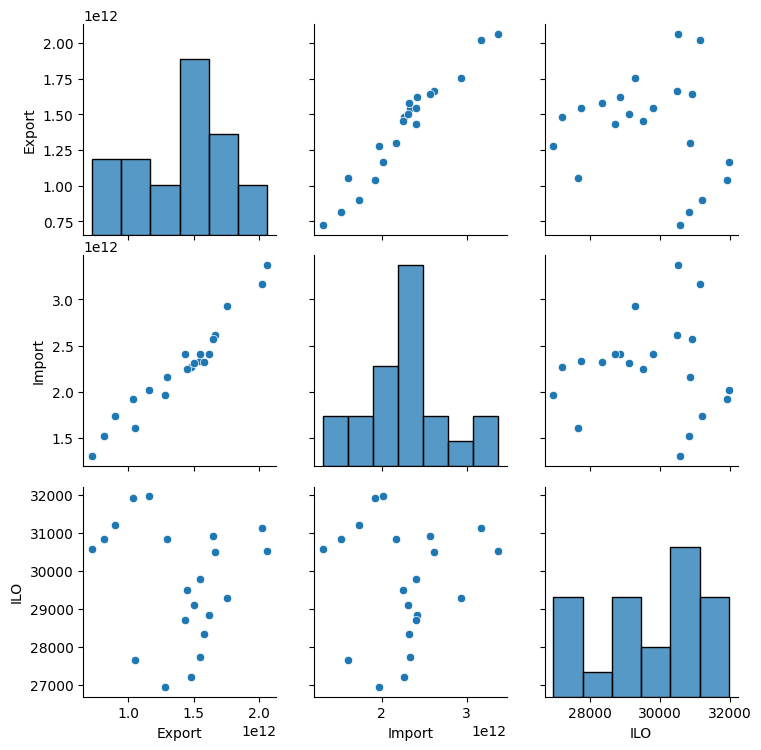

In [ ]:
import seaborn as sns

g = sns.PairGrid(df_merge)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

#Conducting Regression Analysis - Wanonno Iqtyider

                            OLS Regression Results                            
Dep. Variable:            Q("Export")   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.4273
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.521
Time:                        02:25:07   Log-Likelihood:                -587.86
No. Observations:                  21   AIC:                             1180.
Df Residuals:                      19   BIC:                             1182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.447e+12   1.59e+12      1.538      0.1

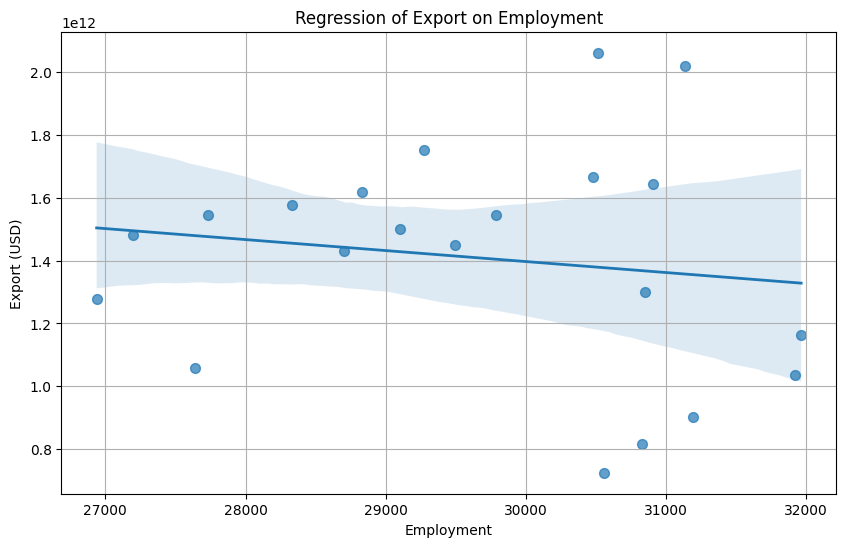

In [ ]:
# 1. Import formula API
import statsmodels.formula.api as smf

# 2. Prepare the data
# Make sure 'employment' and 'total trade value' exist without NaNs
df_regression = df_merge.dropna(subset=["Export", "ILO"]).reset_index()

# 3. Run the regression using formula
# Note: you need to handle spaces in column names by using `Q("column name")` inside the formula
model = smf.ols(formula='Q("Export") ~ ILO', data=df_regression).fit()

# 4. Print regression summary
print(model.summary())

# 5. Visualize with regression line
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.regplot(
    data=df_regression,
    x="ILO",
    y="Export",
    scatter_kws={"s":50, "alpha":0.7},
    line_kws={"linewidth":2}
)
plt.title('Regression of Export on Employment')
plt.xlabel('Employment')
plt.ylabel('Export (USD)')
plt.grid(True)
plt.show()


Employment Data Comparison by Natsuki Konishi

In [102]:
import pandas as pd

# CSVファイルのパス
file_path = '/workspaces/graspp-25S-trade/data/external/ilo_data_raw.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# カラム一覧を出力
print("=== カラム一覧 ===")
for column in df.columns:
    print(f"- {column}")

# データの簡単な概要
print("\n=== データの概要 ===")
print(f"行数: {df.shape[0]}")
print(f"列数: {df.shape[1]}")

# テーマを特定（ここではindicatorカラムの値から推測）
print("\n=== テーマ ===")
indicator_values = df['indicator'].unique()
print(f"このデータセットのテーマ: 各国・各年における産業別労働力統計")
print(f"主要指標: {', '.join(indicator_values)}")

# データの例を表示
print("\n=== データサンプル ===")
print(df.head(3))

=== カラム一覧 ===
- ref_area
- source
- indicator
- classif1
- classif2
- time
- obs_value
- obs_status
- note_classif
- note_indicator
- note_source

=== データの概要 ===
行数: 2009
列数: 11

=== テーマ ===
このデータセットのテーマ: 各国・各年における産業別労働力統計
主要指標: EMP_TEMP_ECO_OCU_NB

=== データサンプル ===
  ref_area    source            indicator        classif1         classif2  \
0      ABW     AA:22  EMP_TEMP_ECO_OCU_NB  ECO_SECTOR_IND  OCU_SKILL_TOTAL   
1      AFG  BA:15715  EMP_TEMP_ECO_OCU_NB  ECO_SECTOR_IND  OCU_SKILL_TOTAL   
2      AFG  BA:15715  EMP_TEMP_ECO_OCU_NB  ECO_SECTOR_IND  OCU_SKILL_TOTAL   

   time  obs_value obs_status  note_classif note_indicator   note_source  
0  2010      6.738        NaN           NaN            NaN   S3:20_T2:83  
1  2021   1463.372        NaN           NaN            NaN  R1:3513_S3:8  
2  2020   1090.912          B           NaN        I11:264       R1:3513  


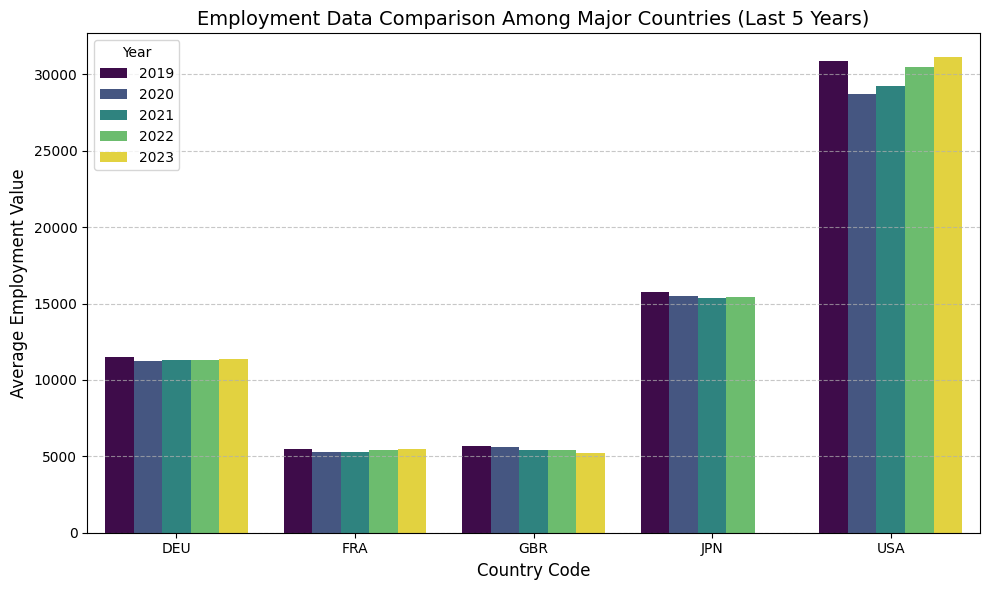

In [104]:
# Simple visualization code
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CSV file
file_path = '/workspaces/graspp-25S-trade/data/external/ilo_data_raw.csv'
df = pd.read_csv(file_path)

# Extract data for specific major countries
major_countries = ["USA", "JPN", "DEU", "GBR", "FRA"]
df_major = df[df['ref_area'].isin(major_countries)]

# Get data for the most recent years
recent_years = df_major['time'].unique()
recent_years = np.sort(recent_years)[-5:]  # Latest 5 years
df_recent = df_major[df_major['time'].isin(recent_years)]

# Calculate average employment values by country and year
df_agg = df_recent.groupby(['ref_area', 'time'])['obs_value'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_agg, x='ref_area', y='obs_value', hue='time', palette='viridis')

# Format the plot
plt.title('Employment Data Comparison Among Major Countries (Last 5 Years)', fontsize=14)
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Average Employment Value', fontsize=12)
plt.legend(title='Year', title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()